In [1]:
%cd ~/p/npworks/20200222-Vero-SCV2/

/blaze/hyeshik/p/npworks/20200222-Vero-SCV2


In [2]:
mods20pct = pd.read_pickle('tmp/per-read-modified-bases-summary.pickle')
mods20cov = pd.read_pickle('tmp/per-read-modified-bases-coverage.pickle')

In [3]:
annotations = pd.read_csv('refs/SARS-CoV-2-annotations.gff', sep='\t',
                         names=['chrom', 'type', 'name', 'start', 'end', '_x', '_y', '_z'])
annotations['start'] -= 1
cdsanno = annotations.iloc[:10]
cdsanno = pd.concat([
    cdsanno,
    pd.DataFrame([pd.Series(['chrSCV', 'CDS', 'ORF1ab', 265, 21555, 0.0, '.', '.'],
              index=cdsanno.columns)])
]).sort_values(by='start').reset_index(drop=True).iloc[:10, :5]

In [4]:
ORFs = cdsanno['name'].tolist()

In [5]:
ORFs

['ORF1ab', 'S', 'ORF3a', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N']

In [6]:
from Bio import SeqIO
covseq = str(next(SeqIO.parse('refs/SARS-CoV-2.fa', 'fasta')).seq).replace('T', 'U')

In [7]:
seqcontexts = mods20pct.index.to_series().apply(lambda x: covseq[x-10:x].lower() + covseq[x:x+1] + covseq[x+1:x+11].lower())
with open('/blaze/hyeshik/nest/modseqcontexts.fa', 'w') as wrtfasta:
    for pos, seq in seqcontexts.iteritems():
        print('>{}\n{}'.format(pos, seq), file=wrtfasta)

In [8]:
import re
purine_pat = re.compile('[AGag]{4,}')

In [9]:
with_purinestretch = seqcontexts.apply(lambda s:
    (len(purine_pat.findall(s)) > 0) and any(
        any(map(str.isupper, frag))
        for frag in purine_pat.findall(s)))

In [10]:
sites_PR = mods20pct[with_purinestretch]
sites_notPR = mods20pct[~with_purinestretch]

with open('/blaze/hyeshik/nest/purinerich.fa', 'w') as wrtfasta:
    for pos, seq in sites_PR['context'].iteritems():
        print('>{}\n{}'.format(pos, seq), file=wrtfasta)
with open('/blaze/hyeshik/nest/purinerich-not.fa', 'w') as wrtfasta:
    for pos, seq in sites_notPR['context'].iteritems():
        print('>{}\n{}'.format(pos, seq), file=wrtfasta)

In [11]:
sites_PR['context']

pos
15947    aucaagAauccua
27267    acuuuuAaaguuu
27485    acuuuuAaaagaa
27947    caccaaGaaugua
28590    caguccAagaugg
28611    cuaccuAggaacu
28652    cuaacaAagacgg
28700    caccaaAagauca
28804    agcagaGgcggca
28859    caagaaAuucaac
28897    ccugcuAgaaugg
29015    ucacuaAgaaauc
29040    uucuaaGaagccu
29126    aaggaaAuuuugg
29154    cagacaAggaacu
29297    augacaAagaucc
29312    auuucaAagauca
29377    gagccuAaaaagg
29407    gaugaaAcucaag
29775    aaugcuAgggaga
Name: context, dtype: object

In [12]:
sites_notPR['context']

pos
6890     guaaauUuugucu
12787    aacacaAcaaagg
13749    uuuaagUuuagaa
17584    uuguugAcacugu
21552    aacaacUaaacga
25356    agugcuCaaagga
25459    aggaugCuacucc
26057    uacagaCacuggu
26279    uacguuAauaguu
26296    gcguacUucuuuu
26465    ucuucuGgucuaa
26730    cugcugUuuacag
27105    uugcugCauacag
27164    agcaguGacaaua
27304    uaaaccUcauaau
27382    agauugAuuaaac
27400    ugaaaaUuauucu
27884    cacgccUaaacga
28253    gauuucAucuaaa
28668    cauaugGguugca
28788    cuucuaCgcagaa
28878    cagcagUagggga
28930    gcucuuGcuuugc
28948    cuugacAgauuga
28957    uugaacCagcuug
29087    uaacacAagcuuu
29169    uuacaaAcauugg
29443    cagcaaAcuguga
Name: context, dtype: object

In [13]:
len(sites_PR), len(sites_notPR)

(20, 28)

Filtering out the unstable alignments

In [15]:
IGNOREENDS = 10

sites_PR = sites_PR.copy()
sites_notPR = sites_notPR.copy()

for i, basetrf in cdsanno.iterrows():
    name = basetrf['name']
    if basetrf['name'] in sites_PR.columns:
        sites_PR.loc[sites_PR.index <= basetrf['start'] + IGNOREENDS, name] = 0
        sites_notPR.loc[sites_notPR.index <= basetrf['start'] + IGNOREENDS, name] = 0

In [16]:
MINIMUM_MODFRAC = 0.2

sites_PR = sites_PR[sites_PR.iloc[:, 1:11].max(axis=1) >= MINIMUM_MODFRAC]
sites_notPR = sites_notPR[sites_notPR.iloc[:, 1:11].max(axis=1) >= MINIMUM_MODFRAC]
len(sites_PR), len(sites_notPR)

(20, 21)

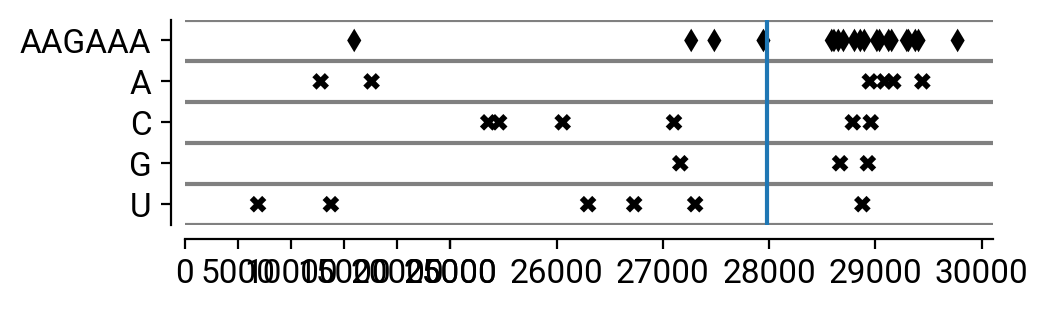

In [18]:
SHRINK_TO = 25000
SHRINK_RATIO = 1/10
def transform_to_xaxis(positions):
    ret = []
    for v in positions:
        if v >= SHRINK_TO:
            ret.append(v)
        else:
            ret.append(SHRINK_TO - (SHRINK_TO - v) * SHRINK_RATIO)
    return ret

XTICKS_MAJOR = np.hstack([np.arange(0, SHRINK_TO+1, 5000), np.arange(SHRINK_TO, 30001, 1000)])
XTICKS_TRANSFORMED = transform_to_xaxis(XTICKS_MAJOR)

fig, ax = plt.subplots(1, 1, figsize=(5.4, 1.7))

ax.scatter(transform_to_xaxis(sites_PR.index),
           [0] * len(sites_PR), c='black', marker='d', edgecolor='none')

for i, (base, marker) in enumerate(zip('ACGU', ['X', 'X', 'X', 'X'])):
    notPRsub = sites_notPR[sites_notPR['context'].apply(lambda x: base in x)]
    ax.scatter(transform_to_xaxis(notPRsub.index),
               [i+1] * len(notPRsub), c='black', marker=marker, edgecolor='none')

ax.set_xticks(XTICKS_TRANSFORMED)
ax.set_xticklabels(XTICKS_MAJOR)
#ax.set_xlim(27000, 30000)
ax.set_yticks(list(range(5)))
ax.set_yticklabels(['AAGAAA', 'A', 'C', 'G', 'U'])
ax.set_ylim(-.5, 4.5)
ax.invert_yaxis()
ax.axhline(1.5, c='gray')
ax.axhline(0.5, c='gray')
ax.axhline(2.5, c='gray')
ax.axhline(3.5, c='gray')
ax.axhline(4.5, c='gray')
ax.axhline(-0.5, c='gray')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.axvline(27977)

plt.tight_layout()
plt.savefig('figure-outputs/motifsites.pdf')

# Motifs aligned by MEME

In [19]:
from io import StringIO

In [20]:
memealns = \
pd.read_csv(StringIO(
"""15947	3	c	a	a	g	a	a	t	9	+	7.34
27485	7	a	a	a	a	g	a	a	13	+	6.98
27947	4	c	a	a	g	a	a	t	10	+	7.34
28590	5	c	c	a	a	g	a	t	11	+	3.97
28611	5	c	t	a	g	g	a	a	11	+	7.87
28652	5	c	a	a	a	g	a	c	11	+	7.25
28700	5	a	a	a	a	g	a	t	11	+	6.58
28804	3	c	a	g	a	g	g	c	9	+	1.02
28859	1	c	a	a	g	a	a	a	7	+	7.73
28897	5	c	t	a	g	a	a	t	11	+	6.64
29015	4	c	t	a	a	g	a	a	10	+	8.36
29040	3	c	t	a	a	g	a	a	9	+	8.36
29126	1	a	a	g	g	a	a	a	7	+	2.97
29154	5	c	a	a	g	g	a	a	11	+	8.57
29297	5	c	a	a	a	g	a	t	11	+	8.67
29312	5	c	a	a	a	g	a	t	11	+	8.67
29377	5	c	t	a	a	a	a	a	11	+	7.52
29407	2	a	t	g	a	a	a	c	8	+	0.953
29775	5	c	t	a	g	g	g	a	11	+	4.32
"""), sep='\t', names='pos start b1 b2 b3 b4 b5 b6 b7 end strand score'.split()).set_index('pos')

In [21]:
memealns

,start,b1,b2,b3,b4,b5,b6,b7,end,strand,score
pos,,,,,,,,,,,
15947,3,c,a,a,g,a,a,t,9,+,7.340
27485,7,a,a,a,a,g,a,a,13,+,6.980
27947,4,c,a,a,g,a,a,t,10,+,7.340
28590,5,c,c,a,a,g,a,t,11,+,3.970
28611,5,c,t,a,g,g,a,a,11,+,7.870
28652,5,c,a,a,a,g,a,c,11,+,7.250
28700,5,a,a,a,a,g,a,t,11,+,6.580
28804,3,c,a,g,a,g,g,c,9,+,1.020
28859,1,c,a,a,g,a,a,a,7,+,7.730


In [22]:
mods_memealned = mods20pct[mods20pct.index.isin(memealns.index)]

In [23]:
alnseqs = mods_memealned.index.to_series().apply(lambda p: covseq[p-10+memealns.loc[p]['start']:p+11+memealns.loc[p]['start']])

In [24]:
colormatch = {
    'a': '<font color="green">a</font><small> </small>',
    'c': '<font color="blue">c</font><small> </small>',
    'g': '<font color="yellow">g</font><small> </small>',
    'u': '<font color="red">u</font><small> </small>',
}

In [25]:
print('\n'.join(
    '{}\t{}'.format(p+1, n)
    for p, n in alnseqs.apply(lambda x: ''.join(colormatch[c] for c in x[1:10].lower())).iteritems()
))

15948	<font color="green">a</font><small> </small><font color="red">u</font><small> </small><font color="blue">c</font><small> </small><font color="green">a</font><small> </small><font color="green">a</font><small> </small><font color="yellow">g</font><small> </small><font color="green">a</font><small> </small><font color="green">a</font><small> </small><font color="red">u</font><small> </small>
27486	<font color="red">u</font><small> </small><font color="red">u</font><small> </small><font color="green">a</font><small> </small><font color="green">a</font><small> </small><font color="green">a</font><small> </small><font color="green">a</font><small> </small><font color="yellow">g</font><small> </small><font color="green">a</font><small> </small><font color="green">a</font><small> </small>
27948	<font color="green">a</font><small> </small><font color="blue">c</font><small> </small><font color="blue">c</font><small> </small><font color="green">a</font><small> </small><font color="green">a

In [26]:
sitecenters = sorted(list(map(int, """
29776 29405 29378 29313 29298 29155 29123 29039 29015 28898 28856 28803 28701 28653 28612 28591 27947 27488 15946 
""".split())))
sitecenters

[15946,
 27488,
 27947,
 28591,
 28612,
 28653,
 28701,
 28803,
 28856,
 28898,
 29015,
 29039,
 29123,
 29155,
 29298,
 29313,
 29378,
 29405,
 29776]

In [27]:
decorate = lambda x: ''.join(colormatch[c] for c in x.lower())

In [28]:
print('\n'.join([decorate(covseq[center-7:center+8]) for center in sitecenters]))

<font color="blue">c</font><small> </small><font color="blue">c</font><small> </small><font color="green">a</font><small> </small><font color="red">u</font><small> </small><font color="blue">c</font><small> </small><font color="green">a</font><small> </small><font color="green">a</font><small> </small><font color="yellow">g</font><small> </small><font color="green">a</font><small> </small><font color="green">a</font><small> </small><font color="red">u</font><small> </small><font color="blue">c</font><small> </small><font color="blue">c</font><small> </small><font color="red">u</font><small> </small><font color="green">a</font><small> </small>
<font color="red">u</font><small> </small><font color="red">u</font><small> </small><font color="red">u</font><small> </small><font color="red">u</font><small> </small><font color="green">a</font><small> </small><font color="green">a</font><small> </small><font color="green">a</font><small> </small><font color="green">a</font><small> </small><font

In [29]:
sitecenters[0]

15946